#### **Imports**

In [10]:
## import essential modules 
import qumcmc 
from qumcmc.basic_utils import *
# from qumcmc.energy_models import IsingEnergyFunction
from qumcmc.energy_models import IsingEnergyFunction, Exact_Sampling

from qumcmc.classical_mcmc_routines import classical_mcmc
from qumcmc.quantum_mcmc_routines_qulacs import quantum_enhanced_mcmc     #for Qulacs Simulator backend (** Faster )
# from qumcmc.quantum_mcmc_routines_qiskit import quantum_enhanced_mcmc   #for qiskit Aer's Simulator backend 

from qumcmc.trajectory_processing import calculate_running_js_divergence, calculate_running_kl_divergence, calculate_runnning_magnetisation, get_trajectory_statistics


In [11]:
import seaborn as sns
sns.set()

#### **Define the Energy Model**

In [12]:
# define the model
np.random.seed(610358)# should always be in the same cell!  ## best seed -> 610358
n_spins = 10

## construct problem Hamiltonian ##
shape_of_J=(n_spins,n_spins)

## defining J matrix (mutual 1-1 interaction)
# J =  np.round(np.random.choice([+1, 0, -1], size=(n_spins, n_spins)), decimals=2) 
J =  np.random.uniform(low= -2, high= 2, size= shape_of_J )

J = 0.5 * (J + J.transpose() )
J = np.round( J - np.diag(np.diag(J)) , decimals= 3)

# defining h
h = np.round(0.5 * np.random.randn(n_spins), decimals=2)
#h = np.round(np.random.uniform(low= -1, high = 1, size= (n_spins)), decimals=2)

# instantiate the model
model = IsingEnergyFunction(J, h, name= 'my_model')


            MODEL : my_model
Non-zero Interactions (J) : 45 / 45
Non-zero Bias (h) : 9 / 10
---------------------------------------------
Average Interaction Strength <|J|> :  0.5966799999999999
Average Bias Strength <|h|>:  0.5010000000000001
alpha :  0.5606804251097042
---------------------------------------------


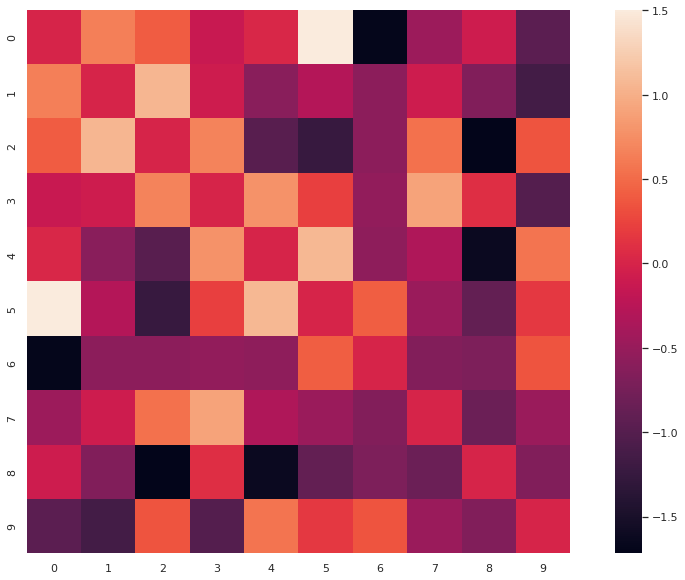

In [13]:
model.model_summary()

#### **Exact Analysis**

In [14]:
## set current beta
beta = 1.100209

## run exact sampling over all possible configurations 
exact_sampled_model = Exact_Sampling(model, beta)

Running Exact Sampling | beta :  1.100209


running over all possible configurations: 100%|██████████| 1024/1024 [00:00<00:00, 12174.81it/s]

saving distribution to model ...


     MODEL : my_model |  beta : 1.100209
Num Most Probable States : 12
Entropy : 3.7838182697705967
---------------------------------------------


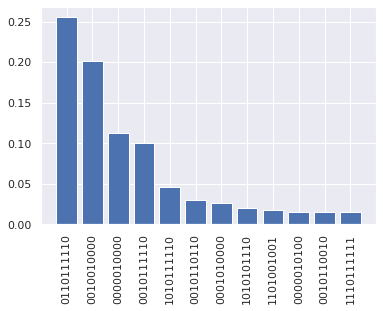

In [15]:
## get the distribution from model
bpd = exact_sampled_model.boltzmann_pd

## exact sampling summary
exact_sampled_model.sampling_summary()

#### **Run Classical MCMC**

In [16]:
steps = 10000
cl_chain =classical_mcmc(
    n_hops=steps,
    model=model,
    # return_last_n_states=10,
    temperature=1/beta,
)

starting with:  0101110110 with energy: 1.2780000000000005


running MCMC steps ...: 100%|██████████| 10000/10000 [00:01<00:00, 8906.80it/s]


In [17]:
cl_statistic = get_trajectory_statistics(cl_chain, exact_sampled_model, verbose= False)

#### **Run Quantum Enhaned MCMC**

In [20]:
steps = 10000
qamcmc_chain =quantum_enhanced_mcmc(
    n_hops=steps,
    model=model,
    temperature=1/beta,
)

starting with:  0000001001 with energy: 3.0160000000000013
MCMCChain()


runnning quantum MCMC steps . ..: 100%|██████████| 10000/10000 [05:10<00:00, 32.16it/s]


In [21]:
qumcm_statistic = get_trajectory_statistics(qamcmc_chain, exact_sampled_model, verbose= False)

#### **Sampled Distributions**

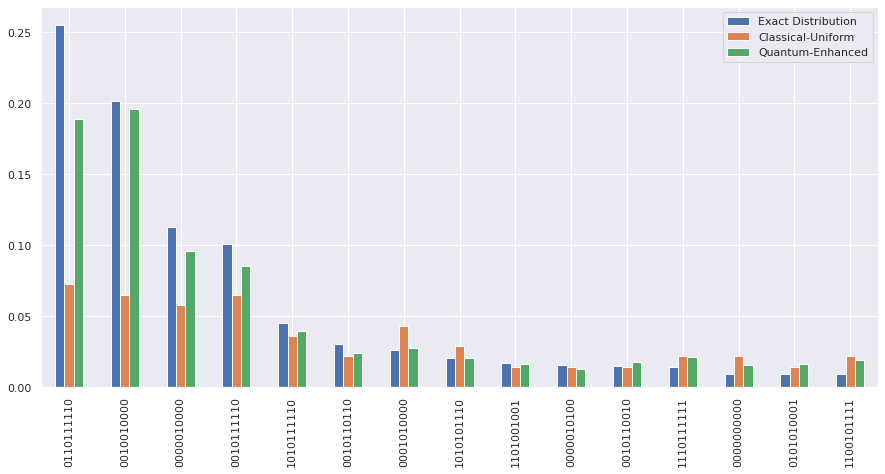

In [32]:
distributions_to_plot = [exact_sampled_model.boltzmann_pd, cl_chain.get_accepted_dict(normalize= True), qamcmc_chain.get_accepted_dict(normalize= True) ]
plot_multiple_bargraphs(distributions_to_plot, ['Exact Distribution', 'Classical-Uniform', 'Quantum-Enhanced'], list_normalise= [False, False, False], plot_first_few=15)

#### **Proposition Strategy Analysis**

Here we analyse the main adavnatge of the Quantum Enhanced MCMC routine, which is to propose transitions which are are more likely to be accepted when compared to usual classical proposition strategies. In the subsequent plots we compare statistics of all proposed transitions with respect to the *Acceptance-Probabilities* , *Energy-Difference*, and the *Hamming-Distance*.

**Acceptance-Probabilities**


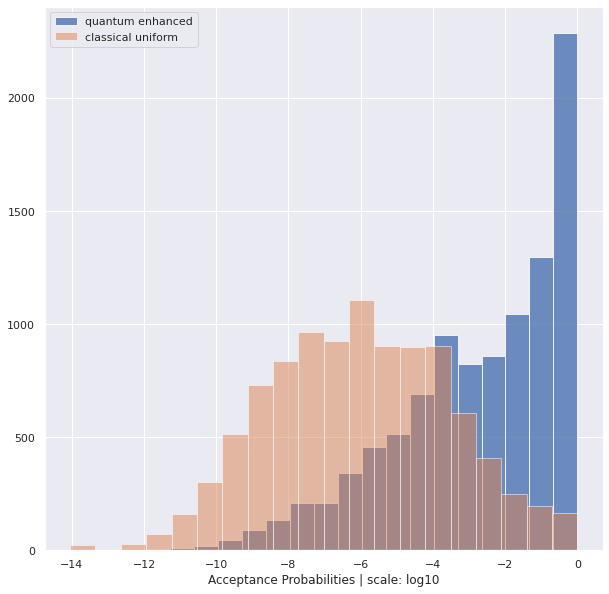

In [22]:
plt.figure(figsize=(10,10))

plt.hist(np.log10(qumcm_statistic['acceptance']),label= 'quantum enhanced' , alpha= 0.8, bins= 20)
plt.hist(np.log10(cl_statistic['acceptance']),label= 'classical uniform' ,alpha= 0.5, bins= 20)


# plt.xscale("log")

plt.xlabel("Acceptance Probabilities | scale: log10")
# plt.ylabel("Hamming Distance")
plt.legend()
plt.show()

The plot depicts that the *Acceptance-Probability* for the *quantum-enhanced* sampling is skewed towards unity, whereas for the *classical-uniform* sampling it is barely close to unity for most of th cases leading to a large rejection rate of the proposed moves.

**Energy-Difference**

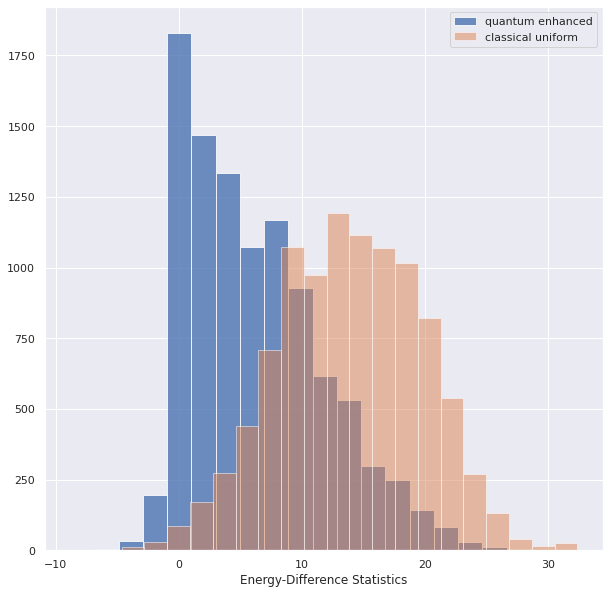

In [23]:
plt.figure(figsize=(10,10))

plt.hist(qumcm_statistic['energy'],label= 'quantum enhanced' , alpha= 0.8, bins= 20)
plt.hist(cl_statistic['energy'],label= 'classical uniform' ,alpha= 0.5, bins= 20)


# plt.xscale("log")

plt.xlabel("Energy-Difference Statistics")
# plt.ylabel("Hamming Distance")
plt.legend()
plt.show()

The plot shows that the *Energy-Difference* of the propose transitions is low for the case of *quantum-enhanced* transitions compared to the *classical-uniform* sampling, this also explains the trend in *Acceptance-Probability* as it is directly dependent on the former.


**Hamming-Distance**

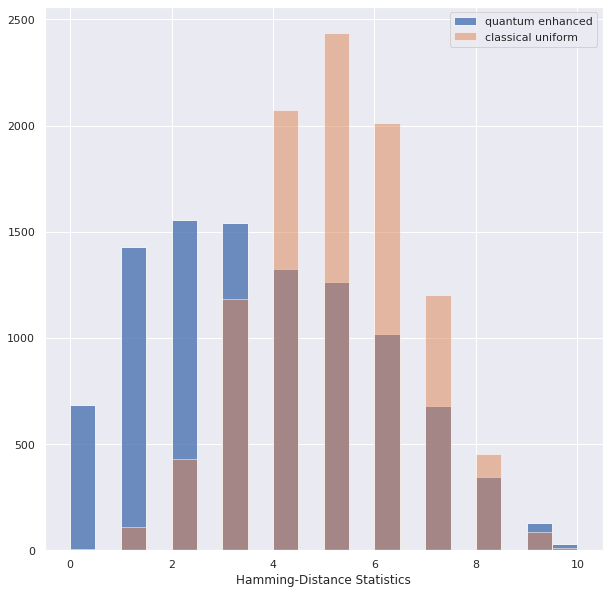

In [24]:
plt.figure(figsize=(10,10))

plt.hist(qumcm_statistic['hamming'],label= 'quantum enhanced' , alpha= 0.8, bins= 20)
plt.hist(cl_statistic['hamming'],label= 'classical uniform' ,alpha= 0.5, bins= 20)


# plt.xscale("log")

plt.xlabel("Hamming-Distance Statistics")
# plt.ylabel("Hamming Distance")
plt.legend()
plt.show()

#### **Convergence Analysis**

##### Magnetisation

In [25]:
magnetization_model = exact_sampled_model.get_observable_expectation(magnetization_of_state)
magnetization_c = calculate_runnning_magnetisation(cl_chain)
magnetization_q = calculate_runnning_magnetisation(qamcmc_chain)

100%|██████████| 10000/10000 [00:16<00:00, 622.54it/s]


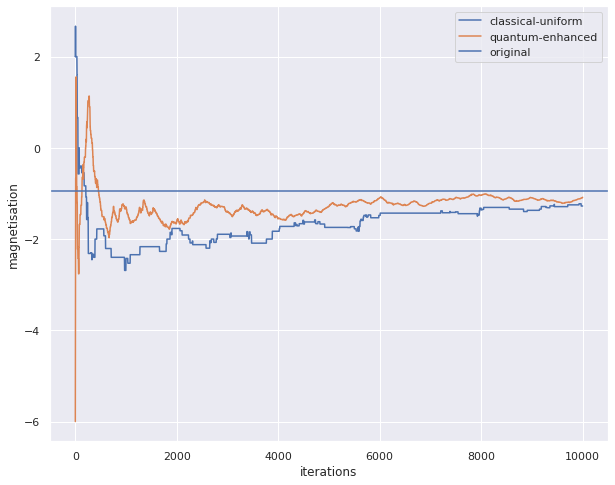

In [33]:
plt.figure(figsize=(10,8))
plt.plot(magnetization_c, label= 'classical-uniform')
plt.plot(magnetization_q, label= 'quantum-enhanced')
plt.axhline(magnetization_model, label= 'original')
plt.xlabel("iterations")
plt.ylabel("magnetisation")
plt.legend()
plt.show()

##### KL Divergence

In [29]:
kldiv_c = calculate_running_kl_divergence(exact_sampled_model.boltzmann_pd, cl_chain)
kldiv_q = calculate_running_kl_divergence(exact_sampled_model.boltzmann_pd, qamcmc_chain)

100%|██████████| 10000/10000 [02:02<00:00, 81.69it/s]


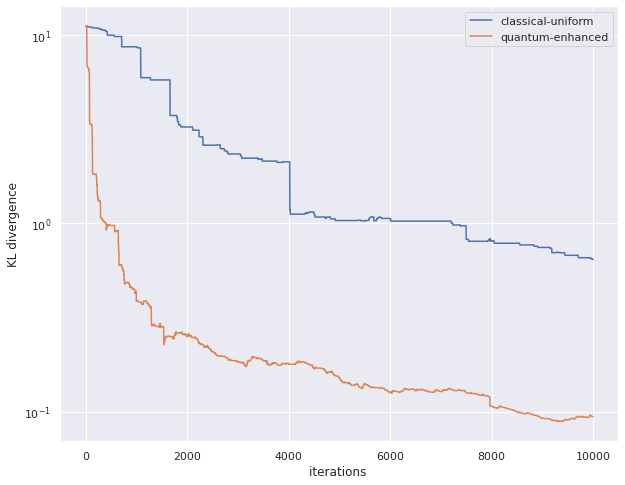

In [34]:
plt.figure(figsize=(10,8))
plt.plot(kldiv_c, label= 'classical-uniform')
plt.plot(kldiv_q, label= 'quantum-enhanced')
plt.xlabel("iterations ")
plt.ylabel("KL divergence")
plt.yscale('log')
plt.legend()
plt.show()
